# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from typing import List

# Création du Dataset

In [ ]:
points = np.array([
    [1, 1],
    [2, 1],
    [2, 2],
    [1, 2]
])
classes = np.array([
    1,
    1,
    -1,
    0
])

# Affichage du dataset

In [3]:
colors = ['blue', 'blue', 'red', 'green']

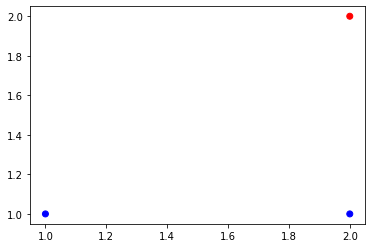

In [4]:
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

# Classification

## Modèle Linéaire

### Initialisation d'un modèle Linéaire pour une tâche de classification

In [5]:
W = np.random.uniform(-1.0, 1.0, 3)

In [6]:
print(W)

[-0.80086242  0.08311442  0.40966364]


### Affichage de la séparation linéaire avant entrainement (elle est aléatoire)

In [7]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100, row / 100])
    c = 'lightcyan' if np.matmul(np.transpose(W), np.array([1.0, *p])) >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

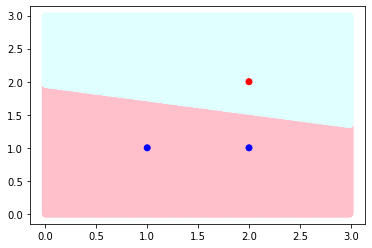

In [8]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

### Entrainement du modèle

In [9]:
for _ in range(10000):
  k = np.random.randint(0, len(points))
  yk = classes[k]
  Xk = np.array([1.0, *points[k]])
  gXk = 1.0 if np.matmul(np.transpose(W), Xk) >= 0 else -1.0
  W += 0.01 * (yk - gXk) * Xk

In [10]:
print(W)

[ 0.03913758  0.10311442 -0.13033636]


### Affichage de la séparation linéaire après entrainement (yay !)

In [11]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100, row / 100])
    c = 'lightcyan' if np.matmul(np.transpose(W), np.array([1.0, *p])) >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

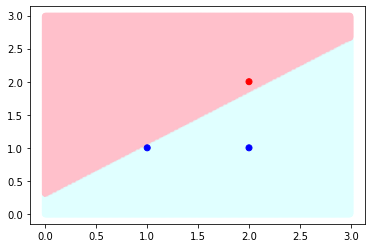

In [12]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

## PMC

### Definition PMC

In [13]:
class PMC:
  def __init__(self, npl: List[int]):
    self.W = []
    self.d = npl.copy()
    self.L = len(npl) - 1
    
    # définitions des caches pour accélérer l'apprentissage
    self.X = []
    self.deltas = []

    # initialisation des W :
    for l in range(len(self.d)):
      self.W.append([])
      if l == 0:
        continue
      for i in range(0, self.d[l - 1] + 1):
        self.W[l].append([])
        for j in range(0, self.d[l] + 1):
          self.W[l][i].append(0.0 if j == 0 else np.random.uniform(-1, 1))

    # initialisation des X et des deltas :
    for l in range(len(self.d)):
      self.X.append([])
      self.deltas.append([])
      for j in range(0, self.d[l] + 1):
        self.deltas[l].append(0.0)
        self.X[l].append(1.0 if j == 0 else 0.0)

  def _propagate(self, inputs: List[float], is_classification: bool):
    for j in range(1, self.d[0] + 1):
      self.X[0][j] = inputs[j - 1]
    
    for l in range(1, len(self.d)):
      for j in range(1, self.d[l] + 1):
          total = 0
          for i in range(0, self.d[l - 1] + 1):
            total += self.W[l][i][j] * self.X[l - 1][i]

          
          self.X[l][j] = total
          if is_classification or l < self.L:
            self.X[l][j] = math.tanh(total)

  def predict(self, inputs: List[float], is_classification: bool) -> List[float]:
    self._propagate(inputs, is_classification)
    return self.X[self.L][1:].copy()

  def train(self, 
            X_train: List[List[float]], 
            Y_train: List[List[float]],
            is_classification: bool, 
            alpha: float = 0.01, 
            nb_iter: int = 10000):
    for it in tqdm(range(nb_iter)):
      k = np.random.randint(0, len(X_train))
      Xk = X_train[k]
      Yk = Y_train[k]

      self._propagate(Xk, is_classification)
      for j in range(1, self.d[self.L] + 1):
        self.deltas[self.L][j] = self.X[self.L][j] - Yk[j - 1]
        if is_classification:
          self.deltas[self.L][j] = self.deltas[self.L][j] * (1 - self.X[self.L][j] ** 2)
      
      for l in reversed(range(2, len(self.d))):
        for i in range(1, self.d[l - 1] + 1):
          total = 0.0
          for j in range(1, self.d[l] + 1):
            total += self.W[l][i][j] * self.deltas[l][j]
          self.deltas[l - 1][i] = (1 - self.X[l - 1][i] ** 2) * total
      
      for l in range(1, len(self.d)):
        for i in range(0, self.d[l - 1] + 1):
          for j in range(1, self.d[l] + 1):
            self.W[l][i][j] += - alpha * self.X[l-1][i] * self.deltas[l][j]      

### Test PMC sans couche cachée sur le dataset du modèle linéaire

In [14]:
model = PMC([2, 1])

In [15]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100, row / 100])
    c = 'lightcyan' if model.predict(p, True)[0] >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

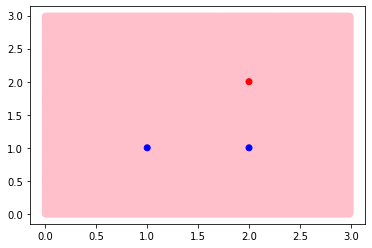

In [16]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

In [17]:
model.train(points, [[c] for c in classes], True)

100%|██████████| 10000/10000 [00:00<00:00, 43558.49it/s]


In [18]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100, row / 100])
    c = 'lightcyan' if model.predict(p, True)[0] >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

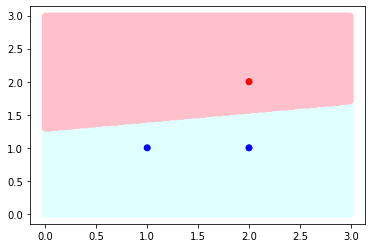

In [19]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.show()

### Test du PMC sur le cas de test XOR

In [20]:
xor_points = np.array([
    [0, 0],
    [1, 1],
    [0, 1],
    [1, 0],
])
xor_classes = np.array([
    -1,
    -1,
    1,
    1,
])

In [21]:
xor_colors = ['blue' if c == 1 else 'red' for c in xor_classes]

In [22]:
model = PMC([2, 2, 1])

In [23]:
for p in points:
  print(model.predict(p, True))

[0.8250936764682975]
[0.836760493105739]
[0.807735169267789]


In [24]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100 -1, row / 100 - 1])
    c = 'lightcyan' if model.predict(p, True)[0] >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

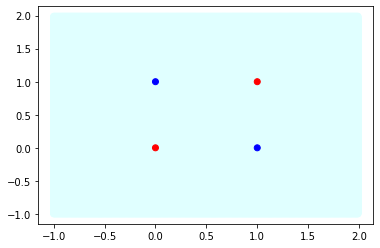

In [25]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(xor_points[:, 0], xor_points[:, 1], c=xor_colors)
plt.show()

In [26]:
model.train(xor_points, [[c] for c in xor_classes], True, nb_iter=100000, alpha=0.01)

100%|██████████| 100000/100000 [00:04<00:00, 21526.27it/s]


In [27]:
test_points = []
test_colors = []
for row in range(0, 300):
  for col in range(0, 300):
    p = np.array([col / 100 -1, row / 100 - 1])
    c = 'lightcyan' if model.predict(p, True)[0] >= 0 else 'pink'
    test_points.append(p)
    test_colors.append(c)
test_points = np.array(test_points)
test_colors = np.array(test_colors)

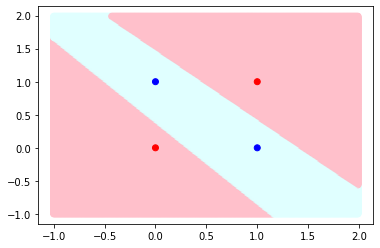

In [28]:
plt.scatter(test_points[:, 0], test_points[:, 1], c=test_colors)
plt.scatter(xor_points[:, 0], xor_points[:, 1], c=xor_colors)
plt.show()